**Checkpoint System:**
- import package & data
- cleaning & preprocessing
- visualization
- label encoder
- spliting data
- training & evaluation
- testing

**1. import package & data**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files
import pandas as pd

# === Upload file dari local device ===
uploaded = files.upload()

# Ambil nama file yang diupload
for filename in uploaded.keys():
    print(f"File {filename} berhasil diupload!")

    # === Baca data sesuai format ===
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.xlsx'):
        df = pd.read_excel(filename)
    else:
        raise ValueError("Format file tidak didukung. Gunakan .csv atau .xlsx")

    # === Tampilkan isi data dalam bentuk tabel ===
    print("\nPreview Data:")
    display(df.head())  # tampil tabel rapi di Colab


Saving earthquake.csv to earthquake.csv
File earthquake.csv berhasil diupload!

Preview Data:


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

**2. cleaning & preprocessing**

In [5]:
# Filter hanya data Gempa Bumi
df = df[df['Type'] == 'Earthquake']

# Hapus kolom yang tidak relevan (ID, Source, dll)
df = df.drop(columns=['Date', 'Time', 'Type', 'ID', 'Source', 'Location Source', 'Magnitude Source', 'Status'])

# Isi NaN di kolom penting, misalnya pakai 0 (atau median/imputasi lain)
df['Root Mean Square'] = df['Root Mean Square'].fillna(0)
df['Depth'] = df['Depth'].fillna(df['Depth'].median())

# Ubah semua NaN jadi 0 (untuk seluruh kolom)
df = df.fillna(0)

In [6]:
def classify_magnitude(mag):
    if mag < 5.8:
        return 'Gempa Kecil'
    elif mag < 6.5:
        return 'Gempa Sedang'
    else:
        return 'Gempa Besar'

# Terapkan fungsi klasifikasi
df['Label'] = df['Magnitude'].apply(classify_magnitude)

In [7]:
df.Label.value_counts()

,count
Label,
Gempa Kecil,11687
Gempa Sedang,9248
Gempa Besar,2297


**3. visualization**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23232 entries, 0 to 23411
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Latitude                    23232 non-null  float64
 1   Longitude                   23232 non-null  float64
 2   Depth                       23232 non-null  float64
 3   Depth Error                 23232 non-null  float64
 4   Depth Seismic Stations      23232 non-null  float64
 5   Magnitude                   23232 non-null  float64
 6   Magnitude Type              23232 non-null  object 
 7   Magnitude Error             23232 non-null  float64
 8   Magnitude Seismic Stations  23232 non-null  float64
 9   Azimuthal Gap               23232 non-null  float64
 10  Horizontal Distance         23232 non-null  float64
 11  Horizontal Error            23232 non-null  float64
 12  Root Mean Square            23232 non-null  float64
 13  Label                       23232 no

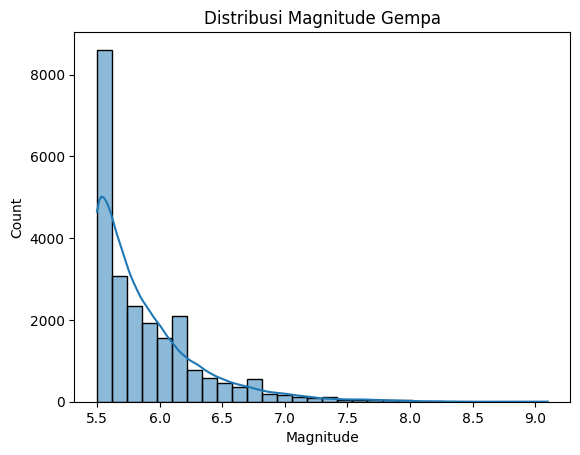

In [9]:
# Cek distribusi Magnitude
sns.histplot(df['Magnitude'], bins=30, kde=True)
plt.title('Distribusi Magnitude Gempa')
plt.show()

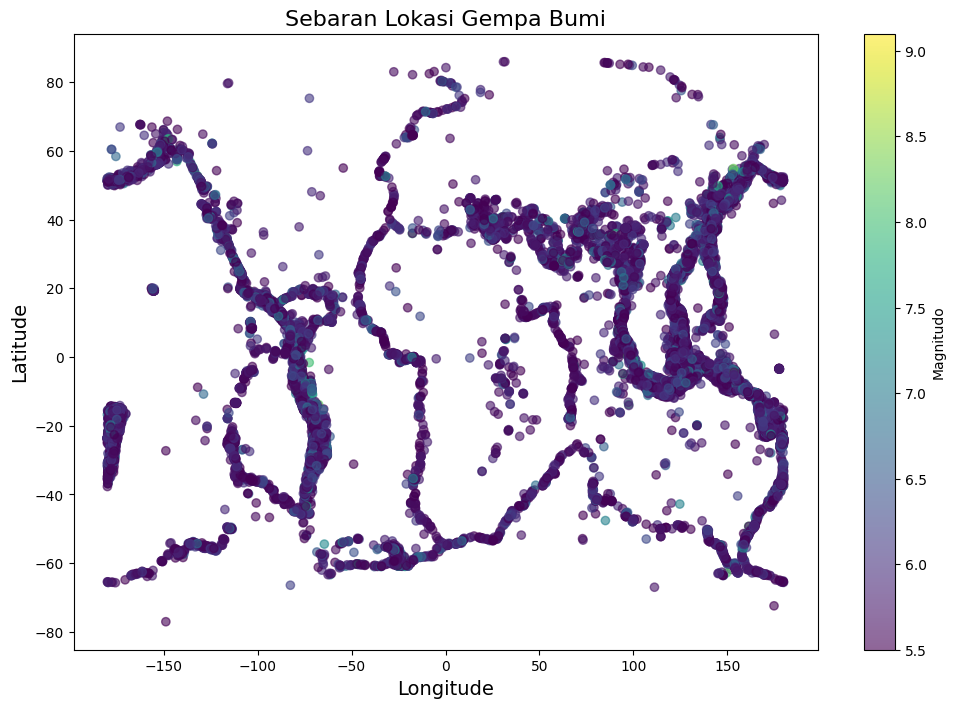

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(df['Longitude'], df['Latitude'],
            c=df['Magnitude'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Magnitudo')
plt.title('Sebaran Lokasi Gempa Bumi', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

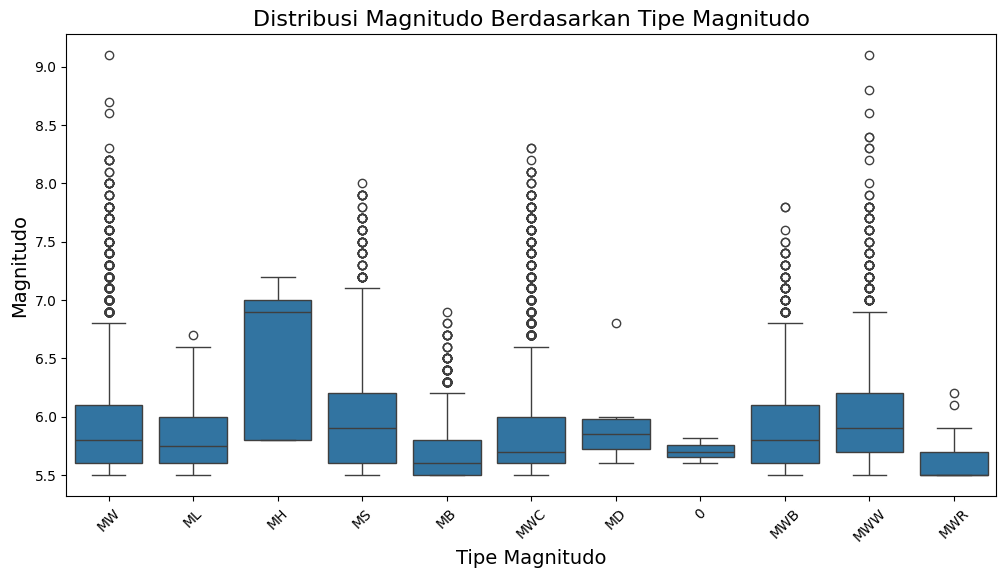

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Magnitude Type', y='Magnitude', data=df)
plt.title('Distribusi Magnitudo Berdasarkan Tipe Magnitudo', fontsize=16)
plt.xlabel('Tipe Magnitudo', fontsize=14)
plt.ylabel('Magnitudo', fontsize=14)
plt.xticks(rotation=45)
plt.show()

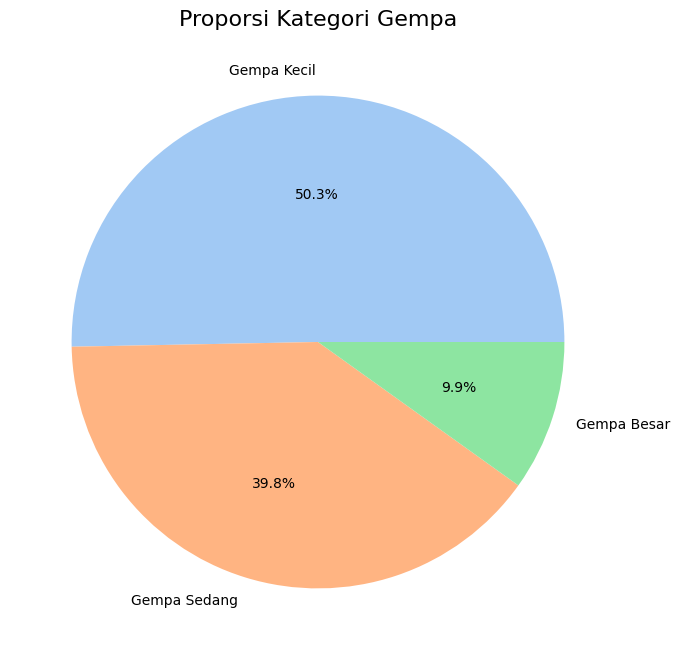

In [12]:
plt.figure(figsize=(8,8))
df['Label'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Proporsi Kategori Gempa', fontsize=16)
plt.ylabel('')
plt.show()

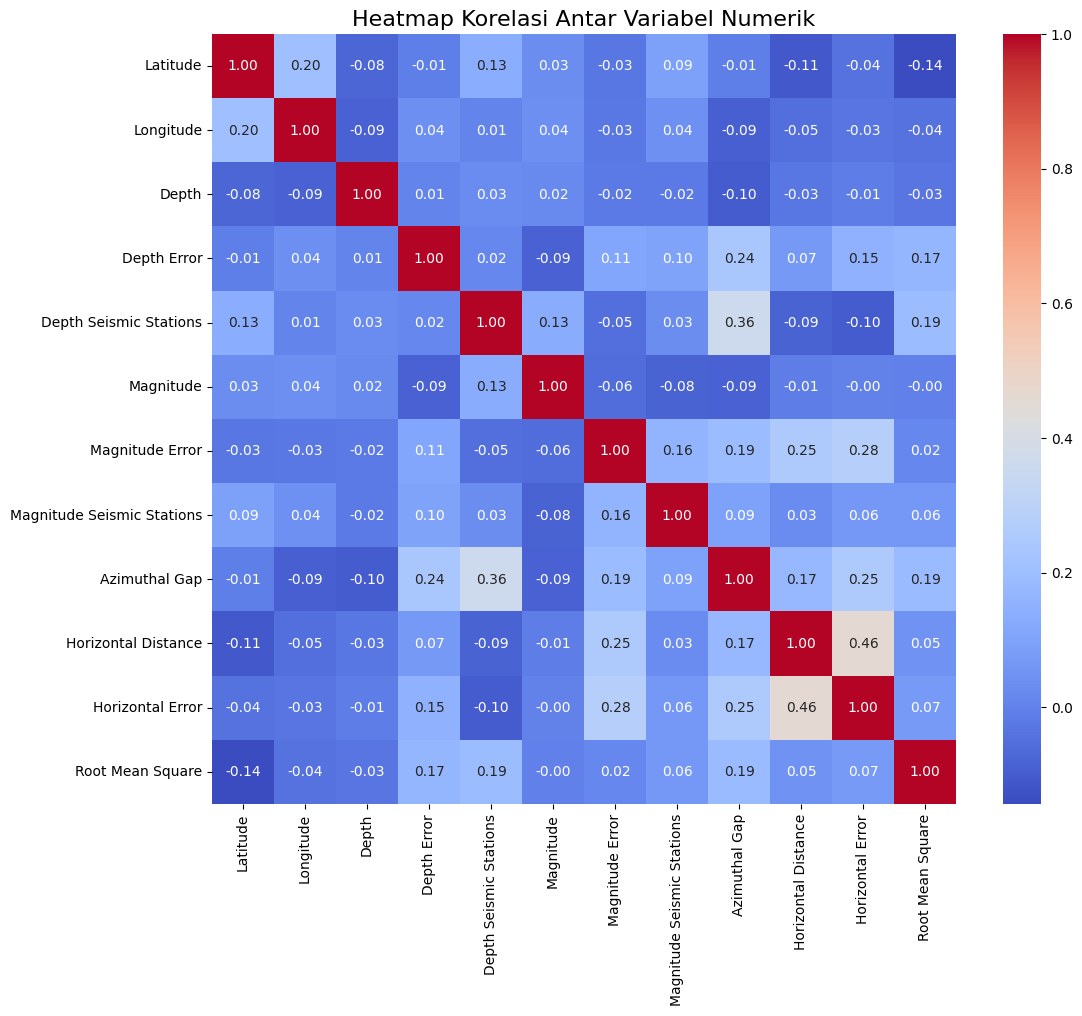

In [13]:
df_corr = df.copy()
df_corr = df_corr.drop(columns = ['Magnitude Type', 'Label'])

plt.figure(figsize=(12,10))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Variabel Numerik', fontsize=16)
plt.show()

In [14]:
df['Magnitude Type'].value_counts()

,count
Magnitude Type,
MW,7722
MWC,5668
MB,3594
MWB,2458
MWW,1983
MS,1702
ML,65
MWR,26
MD,6


**4. label encoder**

In [15]:
le_mt = LabelEncoder()
df['Magnitude Type Encoder'] = le_mt.fit_transform(df['Magnitude Type'].astype(str))

In [16]:
df['Label'] = df['Label'].map({'Gempa Kecil': 0, 'Gempa Sedang': 1, 'Gempa Besar': 2})

In [17]:
df

,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,Label,Magnitude Type Encoder
0,19.2460,145.6160,131.60,0.0,0.0,6.0,MW,0.000,0.0,0.00,0.000,0.0,0.0000,1,6
1,1.8630,127.3520,80.00,0.0,0.0,5.8,MW,0.000,0.0,0.00,0.000,0.0,0.0000,1,6
2,-20.5790,-173.9720,20.00,0.0,0.0,6.2,MW,0.000,0.0,0.00,0.000,0.0,0.0000,1,6
3,-59.0760,-23.5570,15.00,0.0,0.0,5.8,MW,0.000,0.0,0.00,0.000,0.0,0.0000,1,6
4,11.9380,126.4270,15.00,0.0,0.0,5.8,MW,0.000,0.0,0.00,0.000,0.0,0.0000,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,38.3917,-118.8941,12.30,1.2,40.0,5.6,ML,0.320,18.0,42.47,0.120,0.0,0.1898,0,4
23408,38.3777,-118.8957,8.80,2.0,33.0,5.5,ML,0.260,18.0,48.58,0.129,0.0,0.2187,0,4
23409,36.9179,140.4262,10.00,1.8,0.0,5.9,MWW,0.000,0.0,91.00,0.992,4.8,1.5200,1,10
23410,-9.0283,118.6639,79.00,1.8,0.0,6.3,MWW,0.000,0.0,26.00,3.553,6.0,1.4300,1,10


**5. spliting data**

In [18]:
X = df.drop(columns = ['Magnitude Type', 'Label'])
y = df['Label']

print("X : ", X.shape)
print("y : ", y.shape)

X :  (23232, 13)
y :  (23232,)


In [19]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Reshape untuk LSTM: (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (18585, 1, 13)
y_train: (18585,)


**6. training & evaluation**

In [22]:
# Build Model LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


581/581 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4619 - loss: 0.5443 - val_accuracy: 0.8108 - val_loss: -0.4921
Epoch 2/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8000 - loss: -1.1416 - val_accuracy: 0.8317 - val_loss: -3.2692
Epoch 3/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8128 - loss: -4.1156 - val_accuracy: 0.8078 - val_loss: -7.4883
Epoch 4/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8056 - loss: -9.3284 - val_accuracy: 0.8113 - val_loss: -14.0318
Epoch 5/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7998 - loss: -17.5132 - val_accuracy: 0.8012 - val_loss: -24.7492
Epoch 6/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8033 - loss: -28.8175 - val_accuracy: 0.8078 - val_loss: -41.2129
Epoch 7/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8034 - loss: -46.4373 - val_accuracy: 0.7936 - val_loss: -63.7633
Epoch 8/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8004 - loss: -72.3788 - val_a

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8521 - loss: -897.9651
Test Loss: -939.7043, Test Accuracy: 0.8513


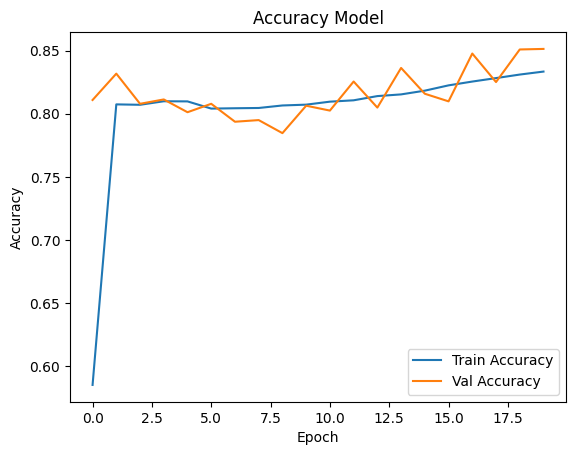

In [23]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Visualisasi hasil training
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


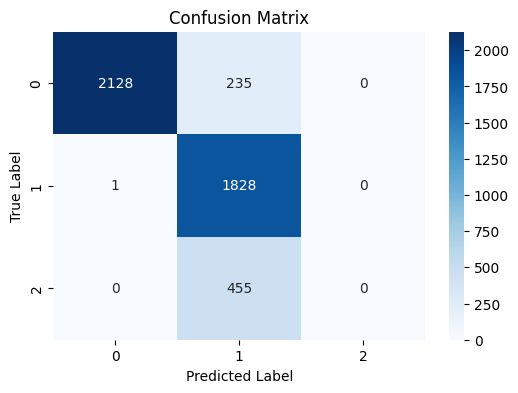

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prediksi data test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # Threshold 0.5 untuk binary classification

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi heatmap confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [25]:
# Prediksi di data test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # Biner threshold 0.5

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95      2363
           1       0.73      1.00      0.84      1829
           2       0.00      0.00      0.00       455

    accuracy                           0.85      4647
   macro avg       0.58      0.63      0.60      4647
weighted avg       0.79      0.85      0.81      4647



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**7. testing**

Upload file Data Testing (CSV/XLSX):


Saving dataTesting.csv to dataTesting (1).csv
Upload file Label Encoder (le_mt.pkl):


Saving le_mt.pkl to le_mt (1).pkl
Upload file Scaler (scaler.pkl):


Saving scaler.pkl to scaler (1).pkl
Upload file Model LSTM (.h5):


Saving lstm_model_earthquake.h5 to lstm_model_earthquake (1).h5
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Preview Data Hasil Prediksi:


/tmp/ipython-input-4019189983.py:102: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(data_test.style.applymap(highlight_label, subset=['Predicted Label Desc']))


,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,Magnitude Type Encoder,Predicted Label Desc
0,-82.664261,-161.389139,627.700003,0.261694,49,4.100000,MWW,0.080424,89,285.011996,314.060795,12.615362,1.292900,10,Gempa Kecil
1,-60.480093,50.401068,49.896189,1.892382,30,4.600000,MWB,0.279021,3,197.581916,254.321981,11.011265,1.776078,7,Gempa Kecil
2,-11.050701,-99.107576,668.262021,1.814721,55,2.800000,MW,0.405876,38,220.644058,819.255105,24.418731,1.197385,6,Gempa Kecil
3,40.468781,-115.196243,458.285157,4.977402,78,8.100000,MW,0.370856,34,81.412939,879.821914,36.878287,1.004307,6,Gempa Sedang
4,16.790157,-148.119990,266.052156,2.231762,72,4.600000,MWW,0.440725,0,304.890742,525.434913,26.261988,0.277743,10,Gempa Kecil
5,27.052953,-142.808775,138.007889,1.667848,86,8.100000,MS,0.138951,23,154.306997,244.339941,1.632284,0.231475,5,Gempa Sedang
6,-3.729793,30.481452,335.428261,2.902375,82,1.800000,MW,0.096977,56,50.745466,112.943208,43.427575,0.308643,6,Gempa Kecil
7,20.833564,67.754832,136.190826,0.443837,8,8.900000,MWB,0.439908,99,239.107649,87.179468,3.234345,0.343697,7,Gempa Sedang
8,-30.776861,-36.943564,116.432125,4.808329,98,4.500000,MWW,0.328780,69,77.792563,719.077447,47.791224,1.275754,10,Gempa Kecil
9,-5.367133,-7.237051,432.146230,3.174800,20,1.400000,MWW,0.155464,40,35.122504,420.118728,1.257098,1.481963,10,Gempa Kecil



Ringkasan Prediksi:
Predicted Label Desc
Gempa Kecil     62
Gempa Sedang    38
Name: count, dtype: int64


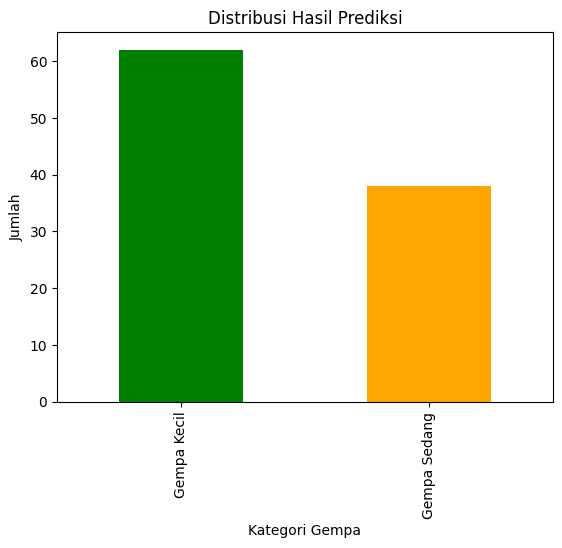


Hasil prediksi disimpan ke hasil_prediksi.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# === Import library ===
from google.colab import files
import pandas as pd
import joblib
import io
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Upload Data Testing
# -------------------------------
print("Upload file Data Testing (CSV/XLSX):")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.csv'):
        data_test = pd.read_csv(io.BytesIO(uploaded[filename]))
    elif filename.endswith('.xlsx'):
        data_test = pd.read_excel(io.BytesIO(uploaded[filename]))
    else:
        raise ValueError("Format file tidak didukung, gunakan CSV atau Excel.")

# Drop kolom jika ada
if 'Magnitude Type Encoder' in data_test.columns:
    data_test = data_test.drop(columns=['Magnitude Type Encoder'])

# -------------------------------
# 2. Upload Label Encoder (pkl)
# -------------------------------
print("Upload file Label Encoder (le_mt.pkl):")
uploaded = files.upload()
for filename in uploaded.keys():
    le_mt = joblib.load(io.BytesIO(uploaded[filename]))

# Encode kolom 'Magnitude Type'
data_test['Magnitude Type Encoder'] = le_mt.transform(data_test['Magnitude Type'])

# -------------------------------
# 3. Upload Scaler (pkl)
# -------------------------------
print("Upload file Scaler (scaler.pkl):")
uploaded = files.upload()
for filename in uploaded.keys():
    scaler = joblib.load(io.BytesIO(uploaded[filename]))

# -------------------------------
# 4. Siapkan Fitur
# -------------------------------
features = [
    'Latitude', 'Longitude', 'Depth', 'Depth Error', 'Depth Seismic Stations',
    'Magnitude', 'Magnitude Error', 'Magnitude Seismic Stations',
    'Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error',
    'Root Mean Square', 'Magnitude Type Encoder'
]

# Scaling
X_new = scaler.transform(data_test[features])

# Reshape untuk LSTM
X_new = X_new.reshape((X_new.shape[0], 1, X_new.shape[1]))

# -------------------------------
# 5. Upload & Load Model LSTM
# -------------------------------
print("Upload file Model LSTM (.h5):")
uploaded = files.upload()
for filename in uploaded.keys():
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])
    model = load_model(filename)

# -------------------------------
# 6. Predict Data Testing
# -------------------------------
predictions = model.predict(X_new)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# -------------------------------
# 7. Mapping Label
# -------------------------------
label_mapping = {0: 'Gempa Kecil', 1: 'Gempa Sedang', 2: 'Gempa Besar'}
data_test['Predicted Label'] = predicted_labels
data_test['Predicted Label Desc'] = data_test['Predicted Label'].map(label_mapping)

# Hapus kolom angka biar clean
data_test = data_test.drop(columns=['Predicted Label'])

# -------------------------------
# 8. Penyajian Data dengan Warna
# -------------------------------
def highlight_label(val):
    if val == "Gempa Kecil":
        color = 'lightgreen'
    elif val == "Gempa Sedang":
        color = 'khaki'
    else:
        color = 'lightcoral'
    return f'background-color: {color}'

print("\nPreview Data Hasil Prediksi:")
display(data_test.style.applymap(highlight_label, subset=['Predicted Label Desc']))

# -------------------------------
# 9. Statistik Ringkas + Grafik
# -------------------------------
print("\nRingkasan Prediksi:")
print(data_test['Predicted Label Desc'].value_counts())

# Visualisasi distribusi hasil
data_test['Predicted Label Desc'].value_counts().plot(
    kind='bar',
    color=['green', 'orange', 'red']
)
plt.title("Distribusi Hasil Prediksi")
plt.xlabel("Kategori Gempa")
plt.ylabel("Jumlah")
plt.show()

# -------------------------------
# 10. Simpan & Download Hasil
# -------------------------------
output_file = "hasil_prediksi.csv"
data_test.to_csv(output_file, index=False)

print(f"\nHasil prediksi disimpan ke {output_file}")
files.download(output_file)
